#### This notebook walks through how to compute area-weighted spatial averages by computing global mean sea surface temperature from a monthly SST climatological observational field. We are using NOAA's OI SST Monthly Long Term Mean 1991-2020 DataSet from https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.highres.html.

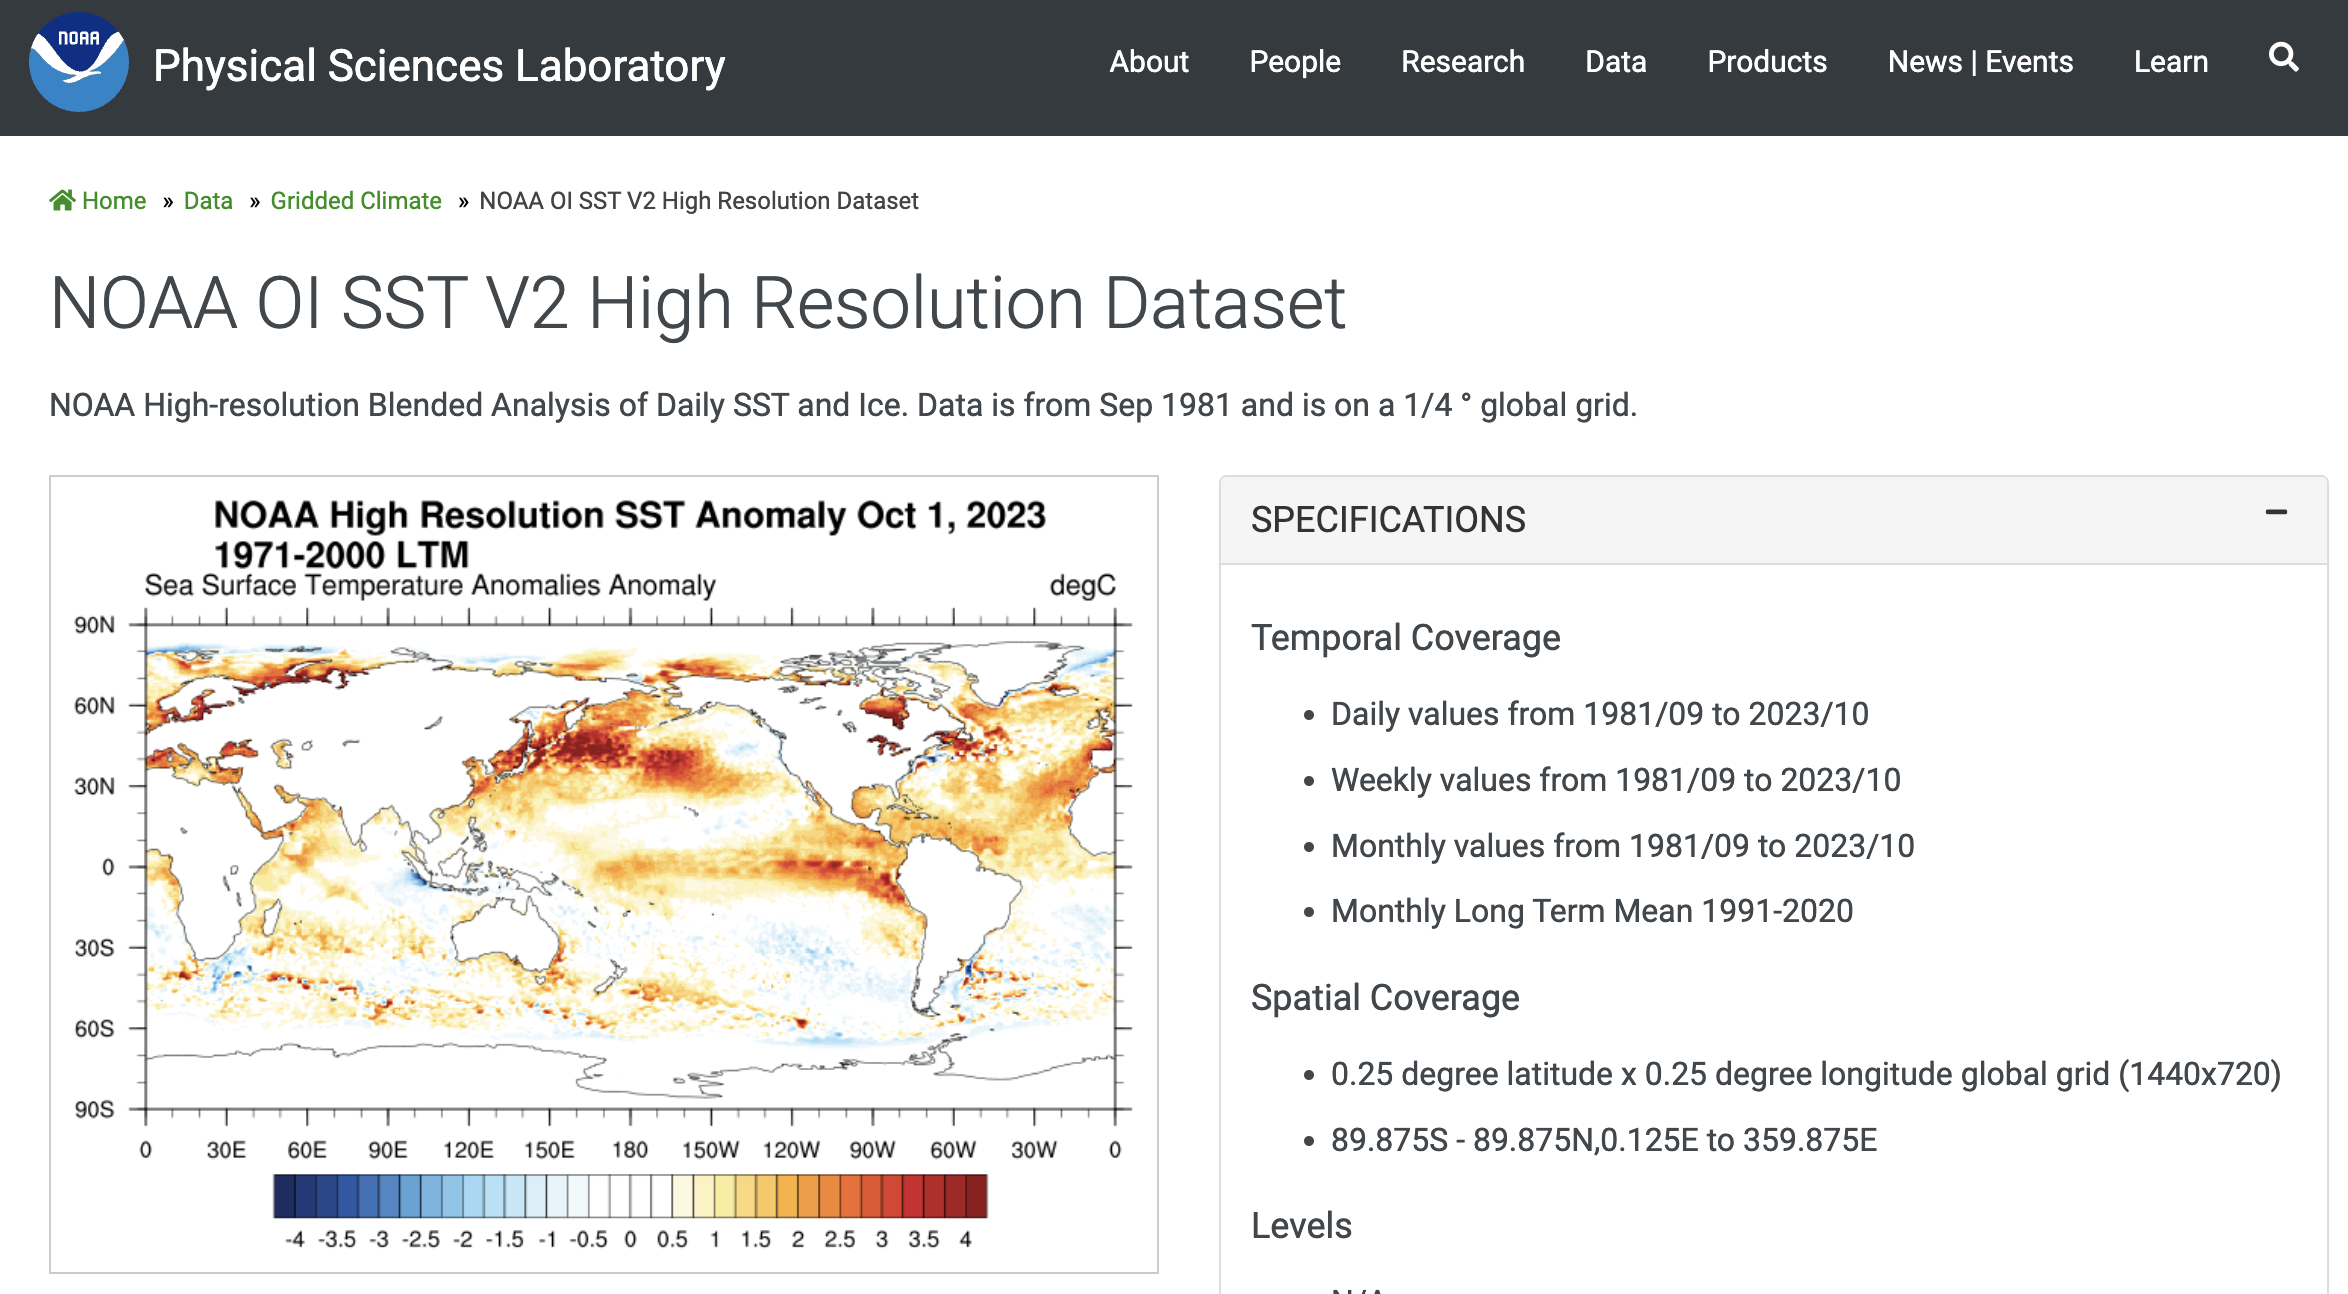

#### __Authors__: Dr. Rebecca L. Beadling, with pieces adapted from tutorial written by Will Ellinger. For any questions regarding the contents of this notebook please contact rebecca.beadling@temple.edu or william.ellinger@temple.edu.

#### You should be __entering__ this lesson with ...
* The ability to read in a netcdf file that contains climate data using Xarray.
* Knowledge of Xarray DataArrays and Datasets.
* Understanding of the differences between __dimensions__, __coordinates__, and __attributes__ of a Dataset and how to view this information.
* Knowledge of __postion based__ indexing (`.isel()`), and __label-based__ indexing (`.sel()`) methods.
* Knowledge of __slicing__ DataArrays.
* Knowledge of computing (_non-weighted_) temporal and spatial averages using Xarrays's `.mean()` method.
* Knowledge of using Xarray's `.plot()` method to create basic visualizations.
* Knowledge of how to use Python functions.

#### You should be __leaving__ this lesson with ...
* Knowledge of what an area-weighted mean is and the importance of it.
* Being able to explain to someone how the size (area) of a 1-degree x 1-degree region changes as a function of latitude on a sphere.
* Knowledge of a useful function to compute grid cell area given data on a regular latitude x longitude grid.
* How to use a land-sea mask.
* An understanding of how to compute an area-weighted mean using Xarray's `.weighted()` method.



In [38]:
import matplotlib.pyplot as plt 
import xarray as xr
import numpy as np 
#import momlevel as ml 

In [39]:
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

In [42]:
## Load a dataset of sea surface temperature (SST) from OISST and assign to a variable called SST_OISST:
SST_OISST = xr.open_dataset('/home/tu.temple.edu/tuq41374/courses/EES3506_5506_Fall2023_Unit4/data/sst.oisst.mon.ltm.1991-2020.nc')

## load in a dataset that contains a land-sea mask (you will see how we use this later)
OISST_landsea_mask = xr.open_dataset('/home/tu.temple.edu/tuq41374/courses/EES3506_5506_Fall2023_Unit4/data/lsmask.nc')

In [43]:
SST_OISST

<xarray.Dataset>
Dimensions:             (lat: 180, lon: 360, time: 12, nbnds: 2)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
  * time                (time) datetime64[ns] 1991-01-01 ... 1991-12-01
Dimensions without coordinates: nbnds
Data variables:
    climatology_bounds  (time, nbnds) datetime64[ns] ...
    sst                 (time, lat, lon) float32 ...
    valid_yr_count      (time, lat, lon) float32 ...
Attributes: (12/13)
    CDI:                            Climate Data Interface version 1.9.10 (ht...
    source:                         NOAA/NCEI https://www.ncei.noaa.gov/data/...
    institution:                    NOAA/National Centers for Environmental I...
    Conventions:                    CF-1.5
    title:                          NOAA/NCEI 1/4 Degree Daily Optimum Interp...
    References:                     https://www.psl.noaa.gov/data/gridded/dat...
    ...                             ...
    version:                        Version 2.1
    comment:                        Reynolds, et al.(2007) Daily High-Resolut...
    CDO:                            Climate Data Operators version 1.9.10 (ht...
    history:                        Created 2023/08/08 by doMonthLTMNC4
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    not_missing_threshold_percent:  minimum 3% values input to have non-missi...

#### Recall from the __Xarray_Fundamentals__ notebook that we learned how to compute basic spatial averages using Xarray's `.mean()` method. When working with global datasets .... we need to take this one step further and compute an __"area-weighted"__ mean, where we take into the account the area of the grid cell that contains the temperature observation (or model result).

#### Why do we need to compute an "area-weighted" mean?? Why can't we just simply average (compute an "arithmetic mean") all the points across the globe?? 

#### __Weighted Average__: When computing a simple average, or arithmetic mean, all numbers are treated equally and assigned equal "weight". A weighted average assigns weights that determine in advance the ___relative importance___ of each data point.

#### The answer lies in the fact that Earth is a sphere and that means when one moves from the equator toward the poles, the distance between degrees of longitude gets smaller. i.e., it would take you less time to walk 360 degrees of longitude if you are standing on the Arctic circle or on the Antarctic continent than if you were standing on the equator.

#### If we have temperature data (or model output) at each grid cell covering the globe, this means that the very very cold temperatures in the polar regions contribute LESS to the global average temperature compared to the warm temperatures at the equator. Simply put ... the regions of extremely cold temperatures "take up less area of the globe" than those of warmer temperatures near the equator. So we need to compute the "temperature per unit area" or the temperature _weighted_ by the size of the grid cell over which it corresponds to and then compute the global average surface air temperature taking this into account!

![](https://www.thoughtco.com/thmb/UrEYthFxKdG0NaAo_a987Qt0lrk=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/Latitude-and-Longitude-58b9d1f35f9b58af5ca889f1.jpg)
<center>source: https://www.thoughtco.com/degree-of-latitude-and-longitude-distance-4070616</center>

#### For data or model output on a regular lat - lon spherical grid we can compute the grid cell area given the lat and lon coordinates of the dataset. The following function is used to compute grid cell area and returns the area as a numpy array.

In [44]:
# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(lat, lon, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = lat[1] - lat[0]
    dLon = lon[1] - lon[0]
    area = np.empty((len(lat), len(lon)))
    for j in range(0, len(lat)):
        for i in range(0, len(lon)):
            lon1 = lon[i] + dLon / 2
            lon0 = lon[i] - dLon / 2
            lat1 = lat[j] + dLat / 2
            lat0 = lat[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

## Compute gridcell area for our SST dataset:

In [45]:
lat_sst = SST_OISST.coords['lat'].values #1-D numpy array of model's latitude values
lon_sst = SST_OISST.coords['lon'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_sst,lon_sst)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.

# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray = xr.DataArray(areacell,dims=({'lat':180, 'lon':360}),\
                                                coords=(SST_OISST.coords['lat'],\
                                                        SST_OISST.coords['lon']))

In [46]:
areacell_xarray

<xarray.DataArray (lat: 180, lon: 360)>
array([[1.07896236e+08, 1.07896236e+08, 1.07896236e+08, ...,
        1.07896236e+08, 1.07896236e+08, 1.07896236e+08],
       [3.23655841e+08, 3.23655841e+08, 3.23655841e+08, ...,
        3.23655841e+08, 3.23655841e+08, 3.23655841e+08],
       [5.39316857e+08, 5.39316857e+08, 5.39316857e+08, ...,
        5.39316857e+08, 5.39316857e+08, 5.39316857e+08],
       ...,
       [5.39316857e+08, 5.39316857e+08, 5.39316857e+08, ...,
        5.39316857e+08, 5.39316857e+08, 5.39316857e+08],
       [3.23655841e+08, 3.23655841e+08, 3.23655841e+08, ...,
        3.23655841e+08, 3.23655841e+08, 3.23655841e+08],
       [1.07896236e+08, 1.07896236e+08, 1.07896236e+08, ...,
        1.07896236e+08, 1.07896236e+08, 1.07896236e+08]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0

#### Create a plot of our new grid cell area field. Our units here are in m^2. We can see from looking at the plot that the a grid cell of 1-degree latitude x longitude has a greater area (yellow colors) near the equator than at the poles. 

Text(0.5, 1.0, 'Atmosphere Grid Cell Area')

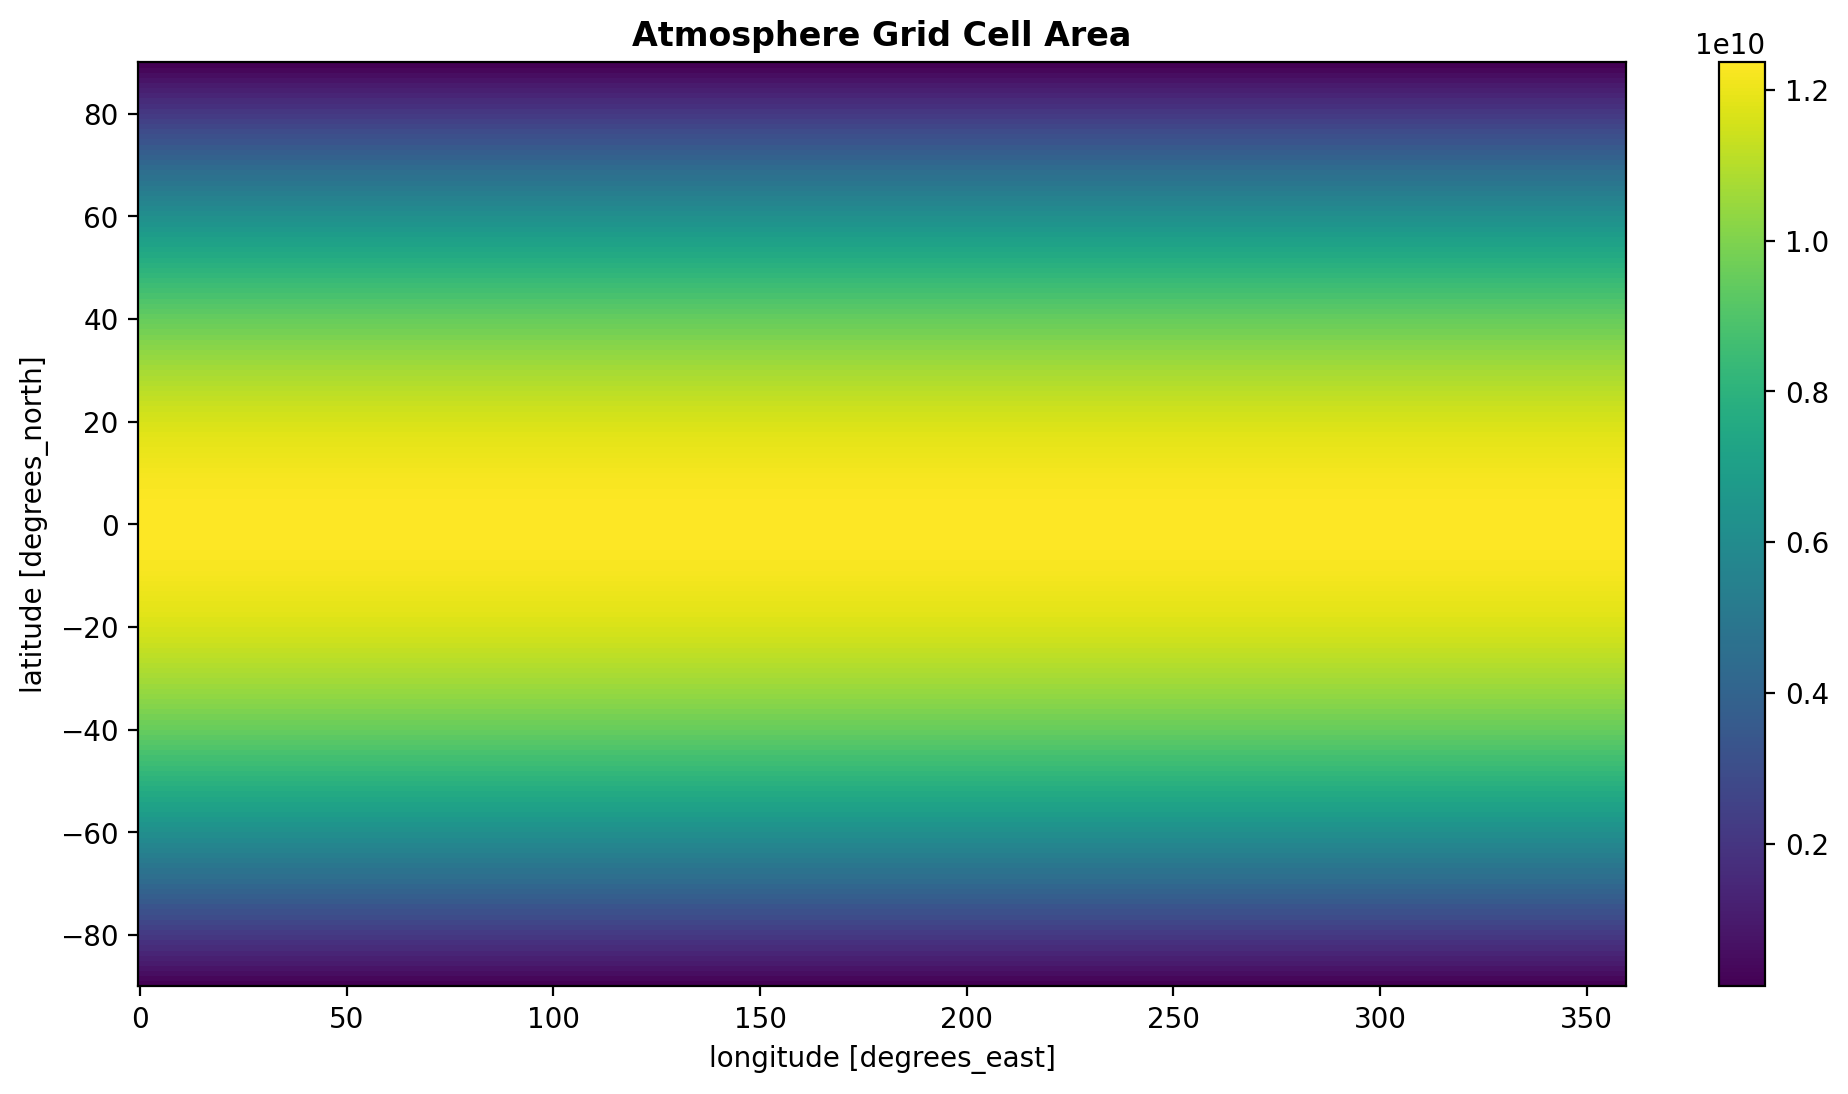

In [22]:
areacell_xarray.plot()
plt.title('Atmosphere Grid Cell Area', fontweight='bold')

#### We can now use this newly created grid cell area to __"weight"__ the temperature measurements in each cell, i.e., how much each temperature contributes to the global average.

#### Since we are working with Sea Surface Temperature data, we must use our land sea mask that we imported to create a "mask" so that only areas over the ocean are counted when we compute our global average:

In [24]:
weights = areacell_xarray*OISST_landsea_mask.mask

#### Producing the plot below shows us now that we have grid cell area information over the ocean, but values of zero over the land.

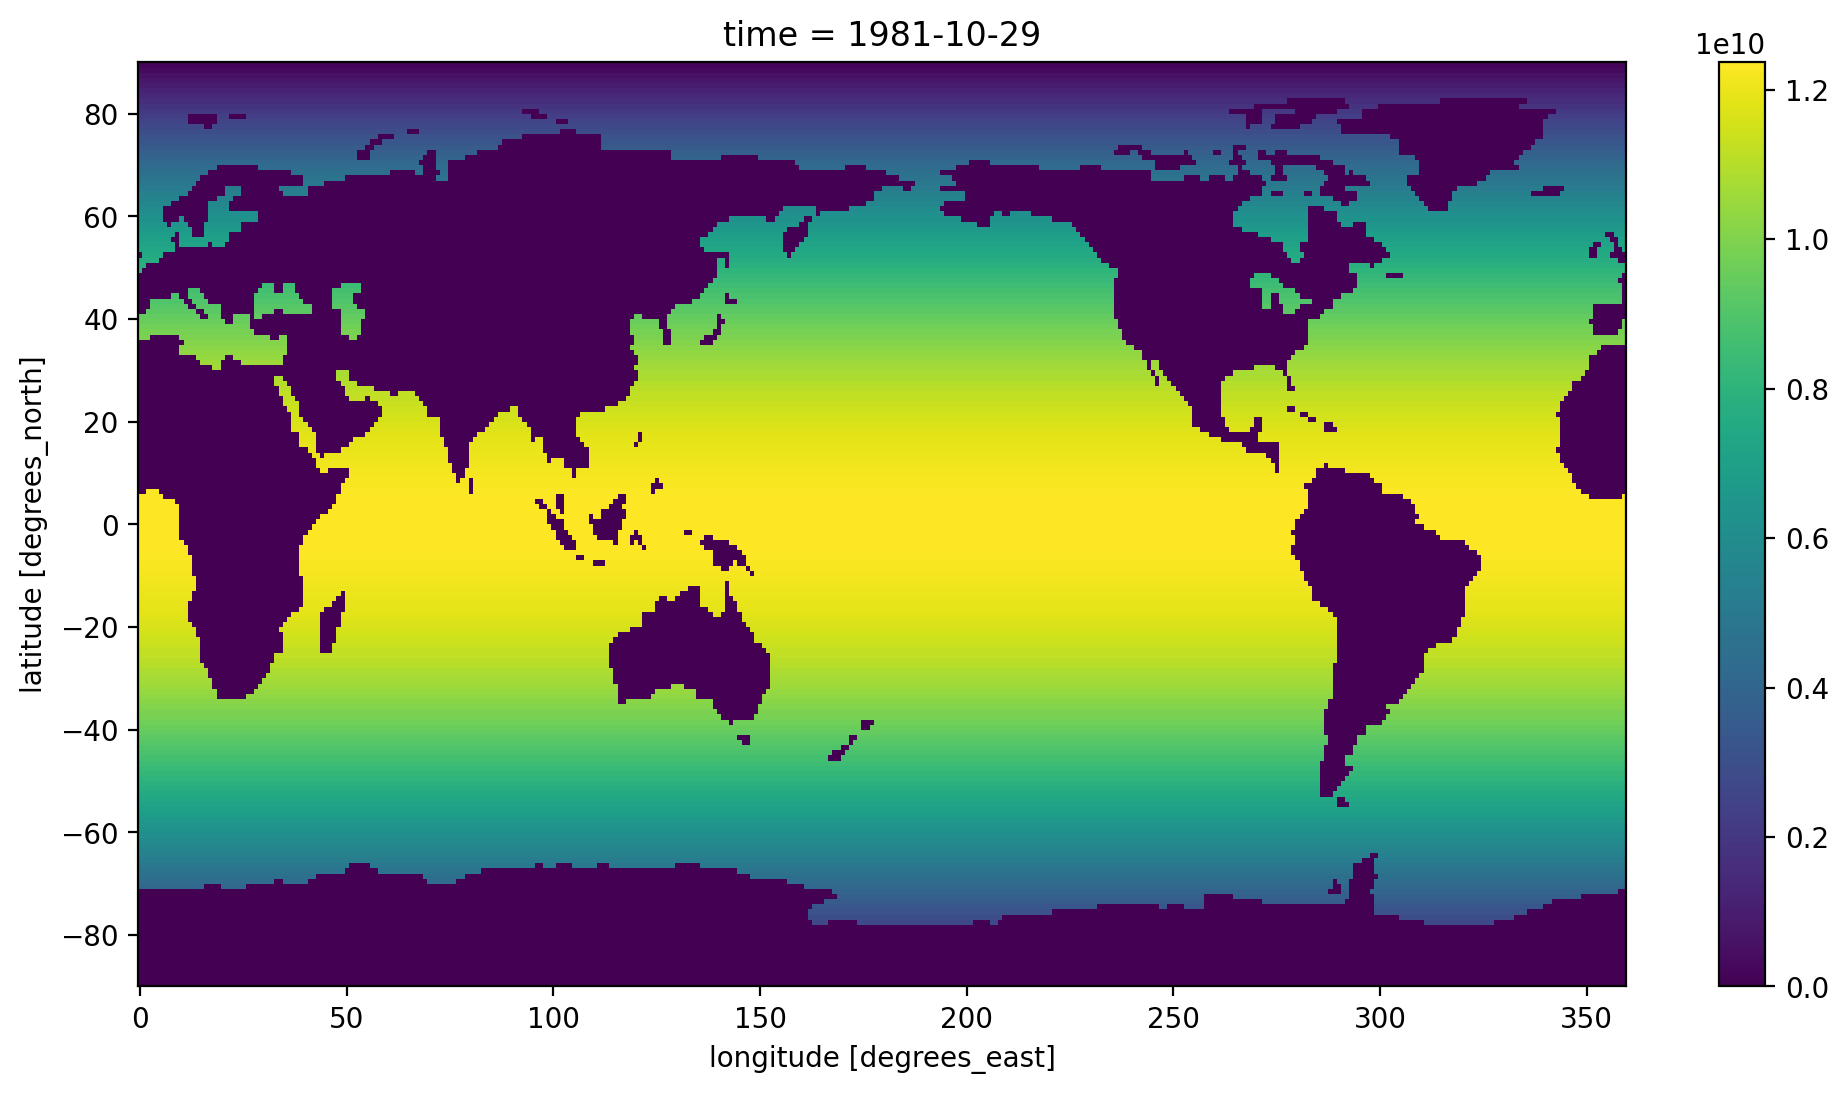

In [25]:
weights.plot()

#### Great!! Now we can compute our area-weighted global average SST using Xarray's `.weighted()` method. Further info can be found here: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.weighted.html
#### Use Xarray's `.mean()` method to and specify 'lat' and 'lon' for dimensions over which to compute the mean. This takes a 3D field (x,y,time) and computes a 1D timeseries of the areaweighted mean.

In [26]:
SST = SST_OISST.sst

In [27]:
weighted_average_SST = SST.weighted(weights).mean(['lat', 'lon']) 

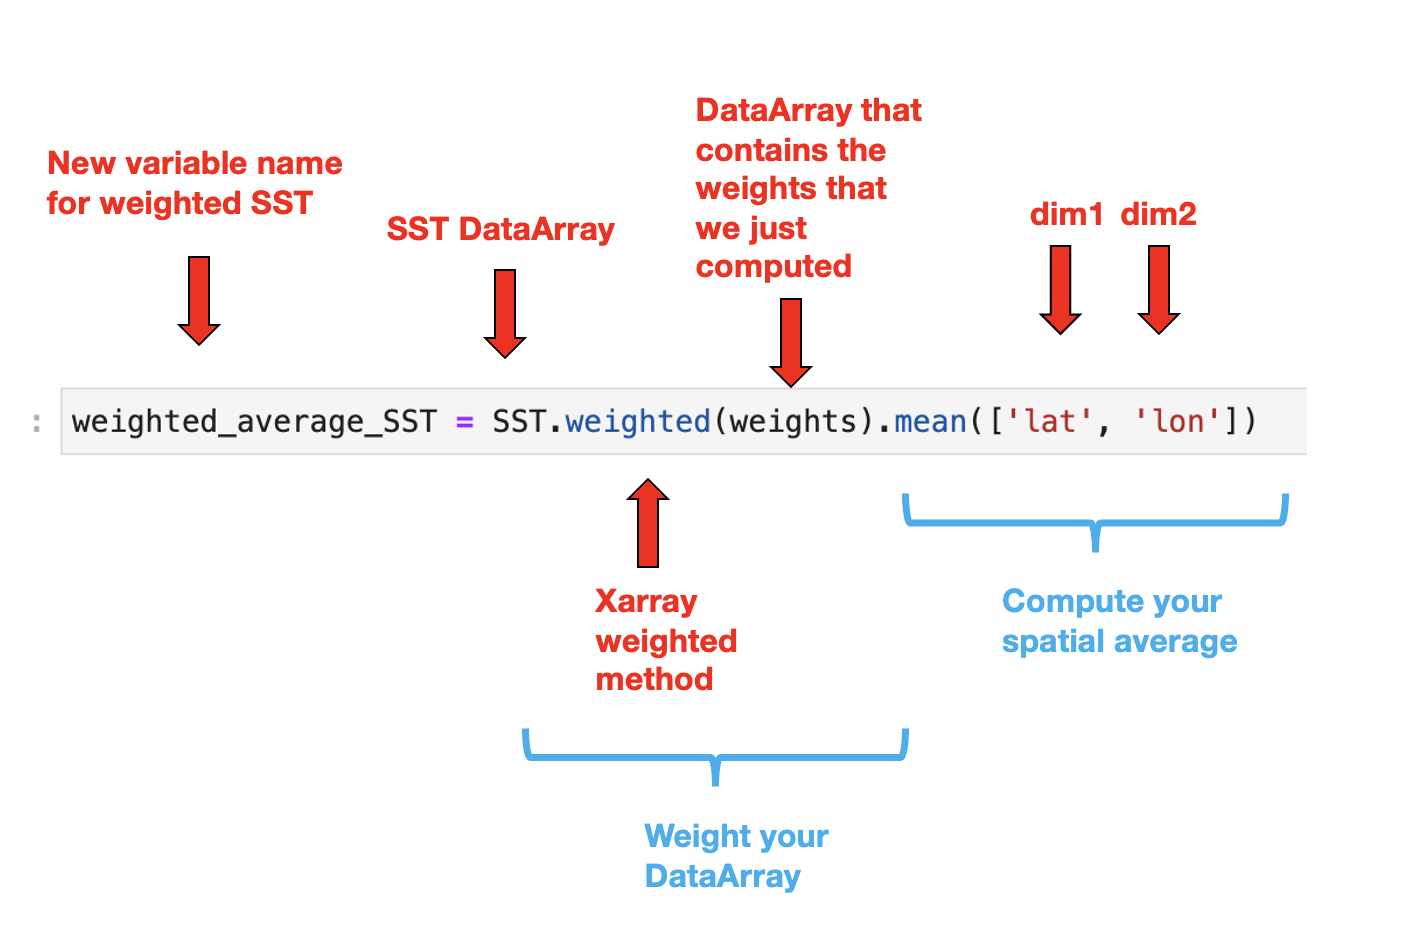

#### Examine our newly created DataArray. We see that our only dimension now is `time`.

In [28]:
weighted_average_SST

<xarray.DataArray 'sst' (time: 12)>
array([18.11154872, 18.24733578, 18.29228569, 18.24951727, 18.181676  ,
       18.16383182, 18.26940581, 18.36870689, 18.27916877, 18.07826328,
       17.9566675 , 17.98454914])
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-02-01 ... 1991-12-01

#### Create a plot of our weighted average SST:

Text(0.5, 1.0, 'Area - Weighted Average Monthly Sea Surface Temperature [degrees C]')

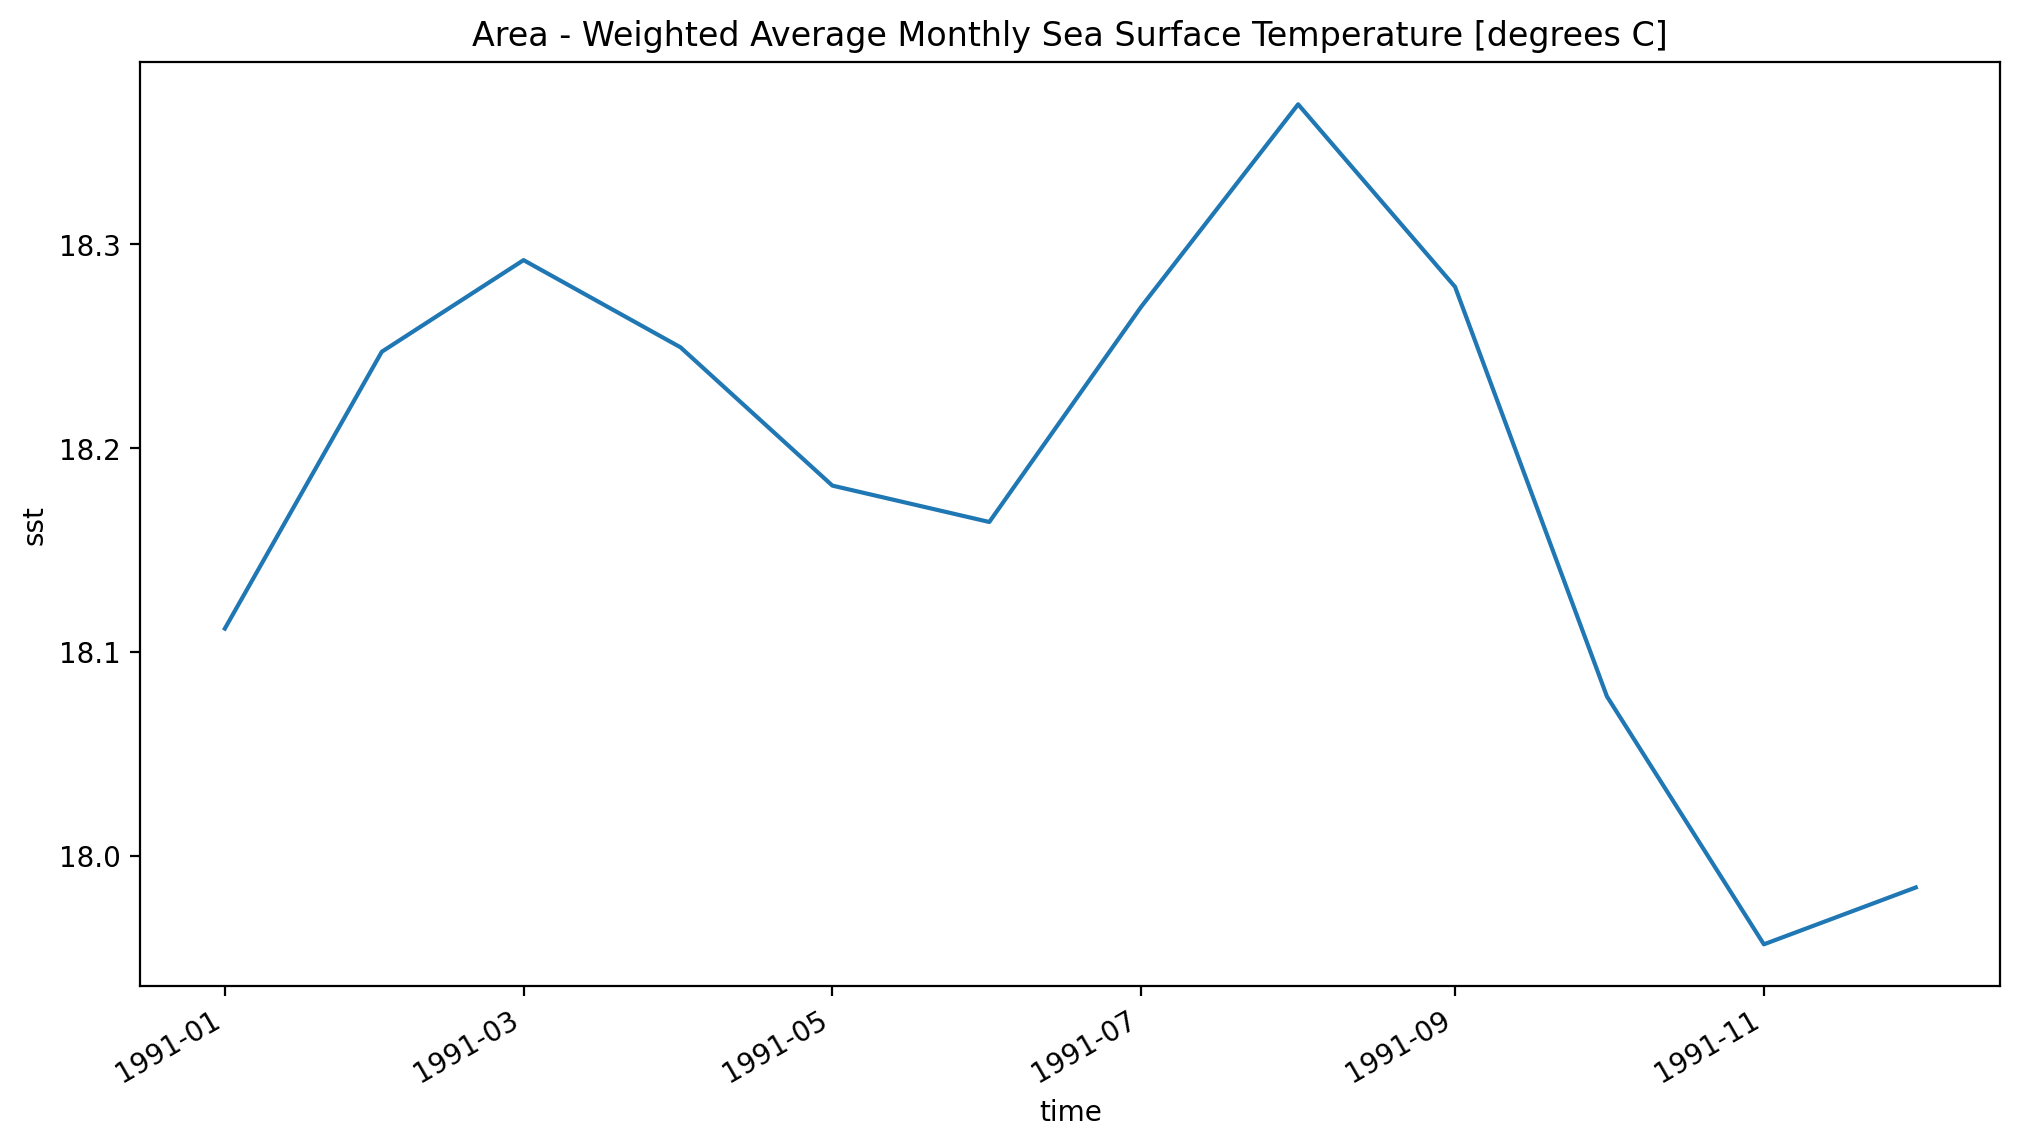

In [29]:
weighted_average_SST.plot()
plt.title('Area - Weighted Average Monthly Sea Surface Temperature [degrees C]')

#### Lets compare our plot above to what we get if we just took the spatial average but without area-weighting:

In [13]:
non_weighted_SST = SST.mean(dim=['lat','lon'])

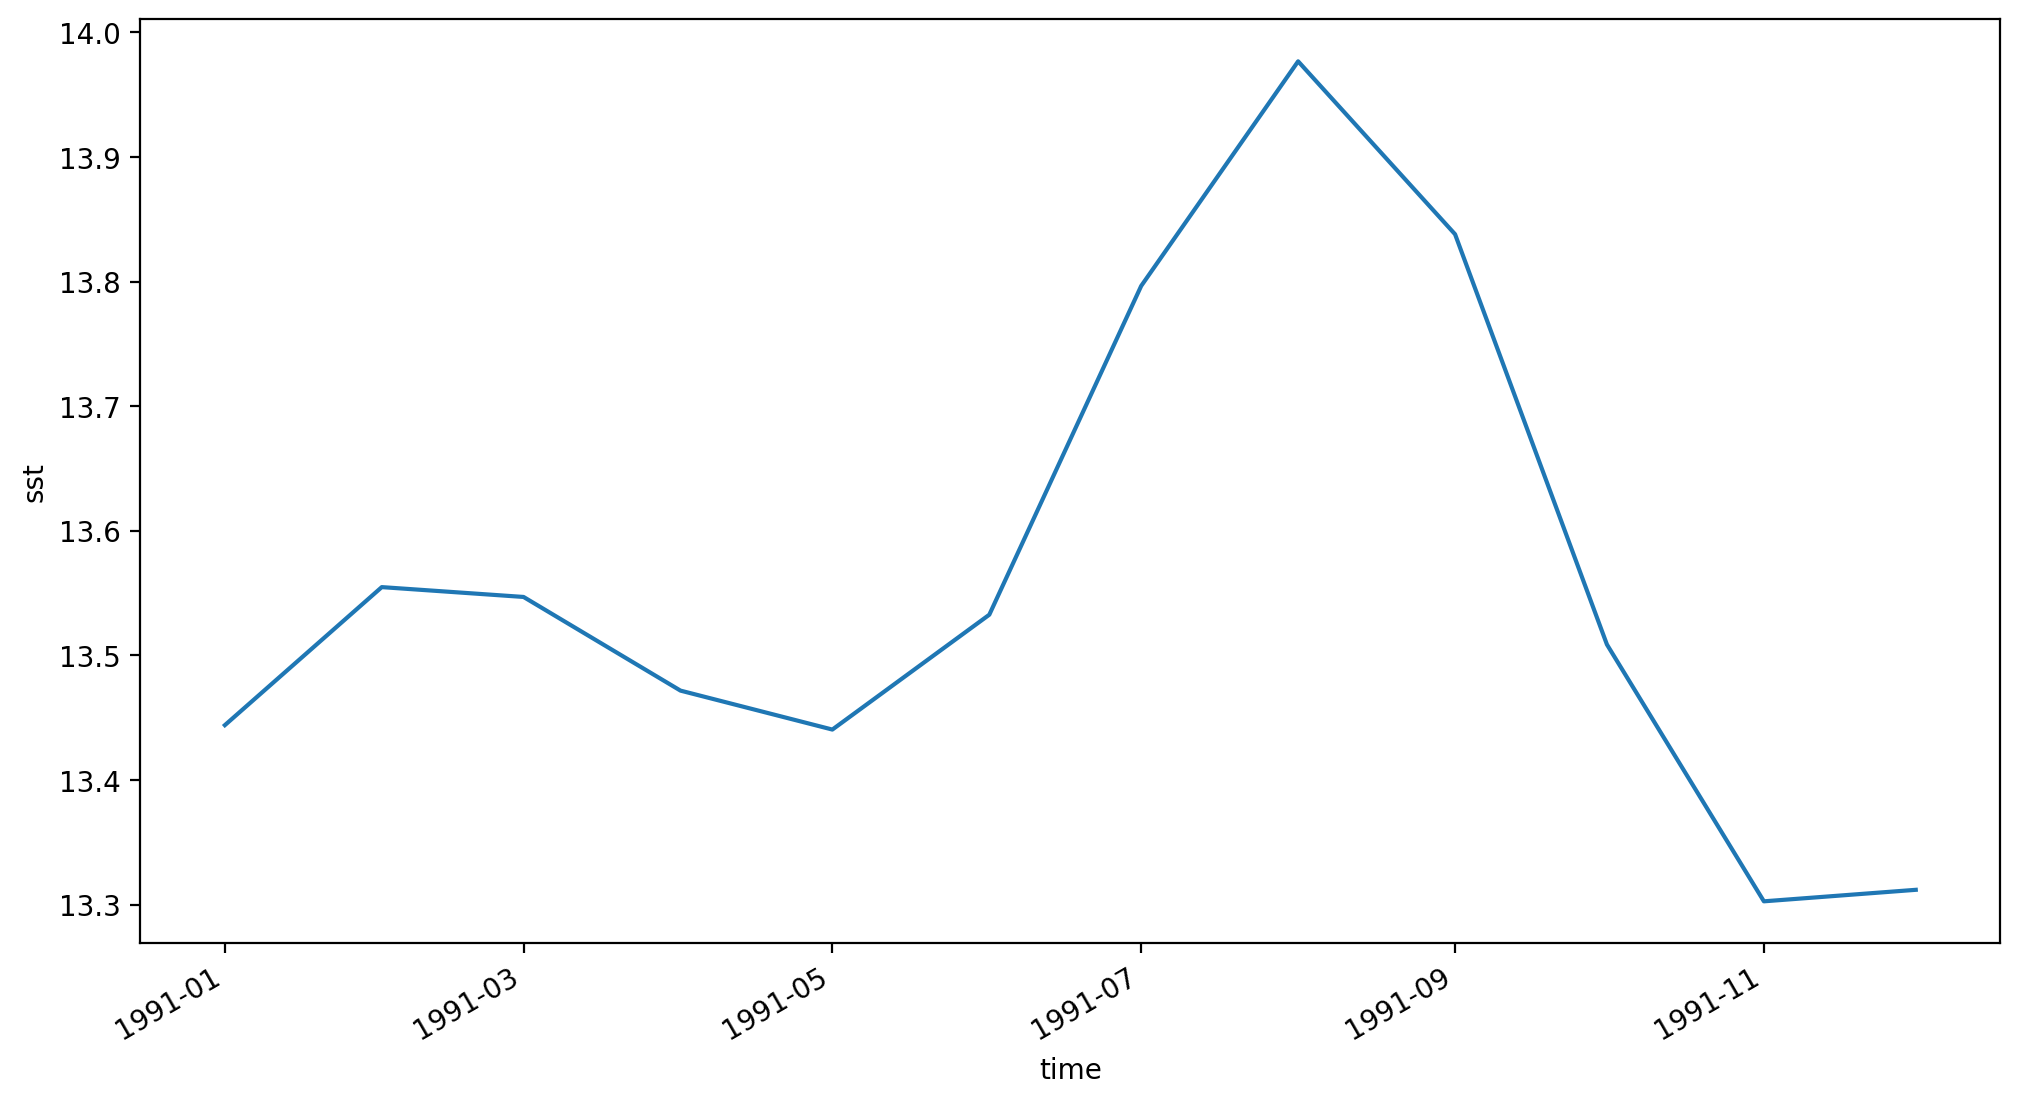

In [14]:
non_weighted_SST.plot()

#### <span style="color:red"> Write code in the cells below that would put the two timeseries on the same plot. 

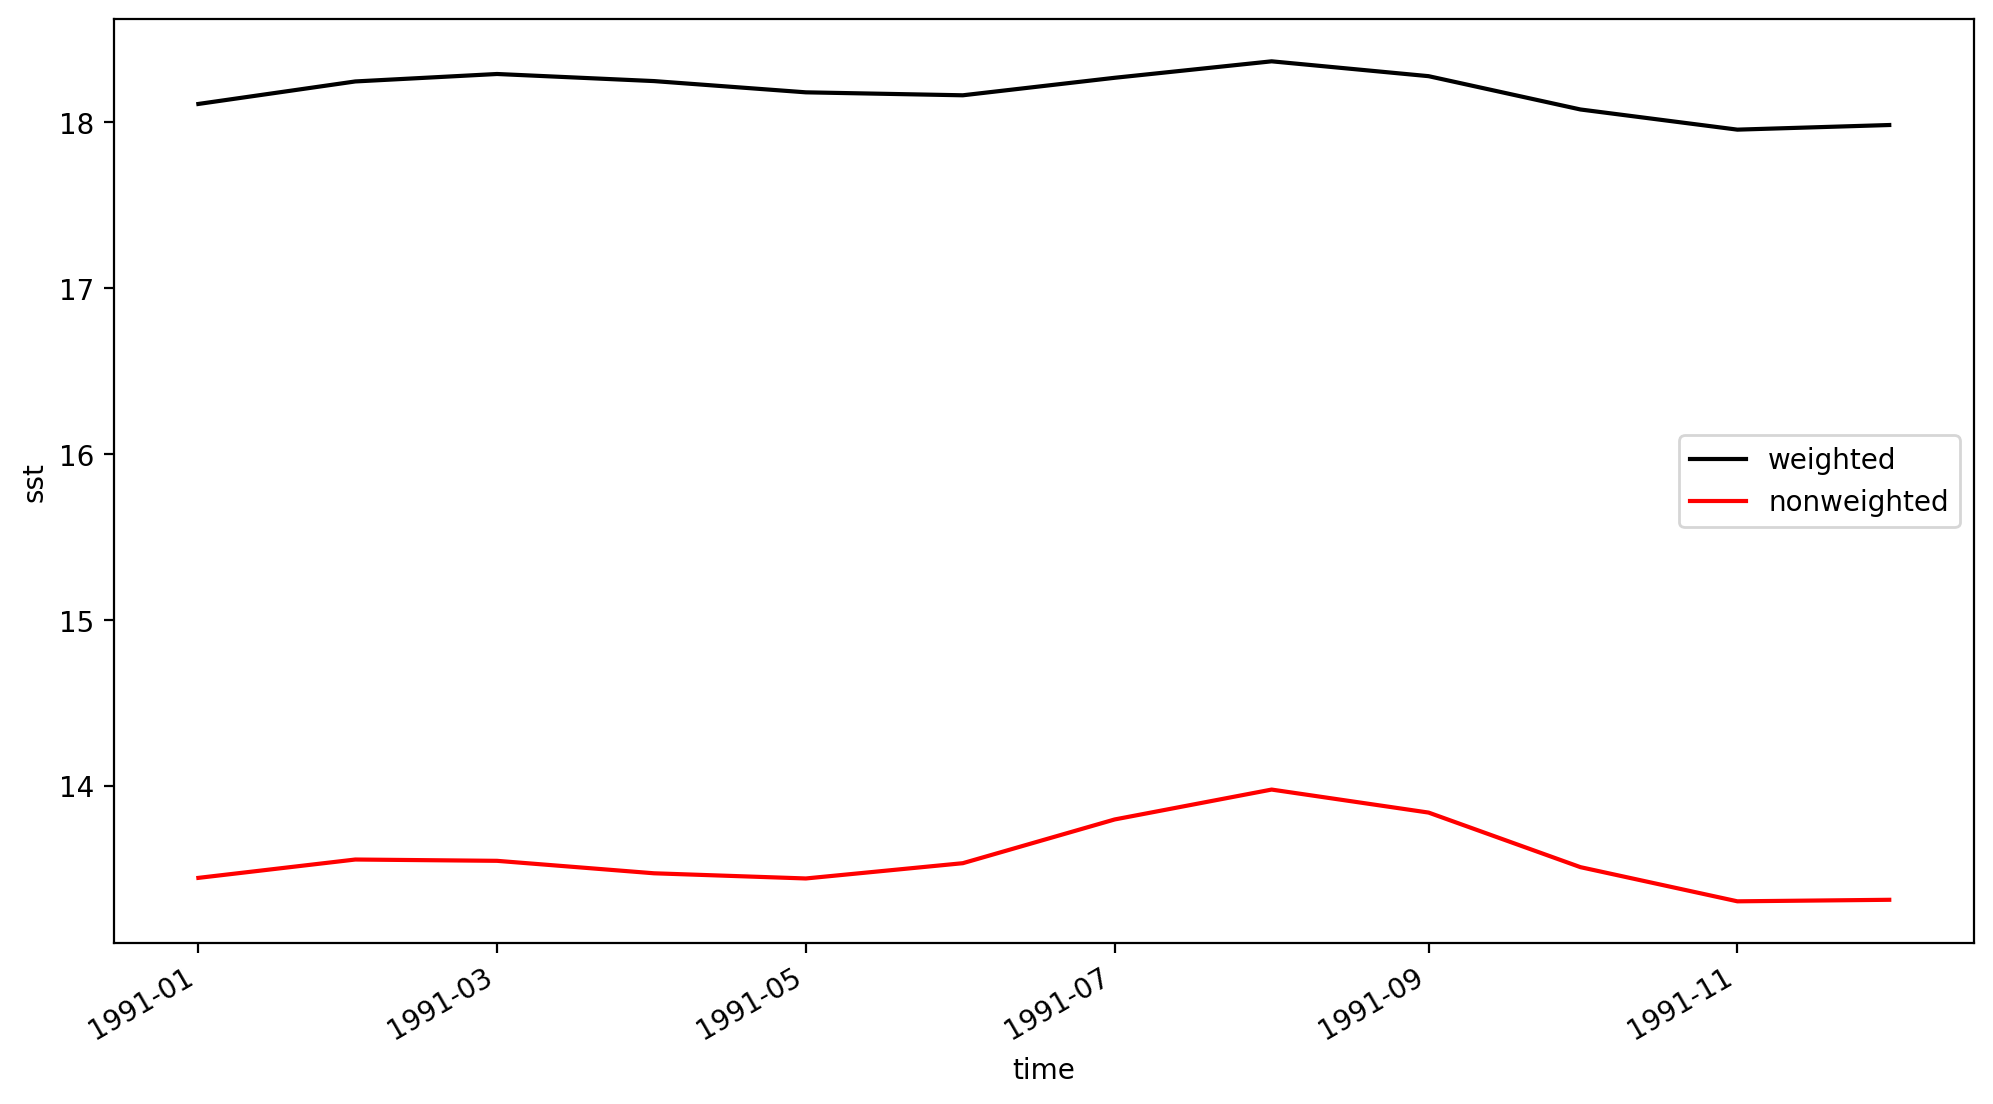

In [32]:
weighted_average_SST.plot(color='black',label='weighted')
non_weighted_SST.plot(color='red',label='nonweighted')
plt.legend()

#### <span style="color:red"> Compute the annual-mean for the weighted and non-weighted SST and then compute the difference. How much warmer is the global mean when compute the proper area-weighted mean SST? Why ?? Place your code and answers in the cells below:

In [34]:
SST_ann_weighted = weighted_average_SST.mean(dim='time')
SST_ann_nonweighted = non_weighted_SST.mean(dim='time')

In [35]:
difference = SST_ann_weighted - SST_ann_nonweighted

In [36]:
difference

<xarray.DataArray 'sst' ()>
array(4.62148539)

#### Plotting the two time series on top of one another shows the importance of area weighting: 

#### By not accounting for the grid cell area in our unweighted field, we make the assumption that cold temperatures at the poles contribute just as much to the global average temperature .... even though the area over which these temperatures exist is much smaller since we are on a spherical grid, the distance between degrees of longitude reduces as one mores poleward away from the equator. Not accounting for grid cell area results in an exceptionally colder global average sea surface temperature!

#### Just like not all grid-cell areas are the same and we must take grid cell area into account when computing 2D spatial averages, when computing annual averages from monthly fields, not every month contributes evenly to the annual average! The days in the month differ! Our next notebook will walk through how to compute a properly weighted annual average from monthly data.

#### <span style="color:red"> Do not forget that you must have answers for all the red cells in this notebook and add and push it to GitHub when complete!!

#### Shutting down your notebook (__don't do this yet!!__ These are just instructions for when class is over).
#### Before shutting down, save your notebook with the disc icon in the Notebook toolbar. Go to the the File menu and click Shut Down to close the browser table and Jupyter Lab itself.